In [1]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import fiona

In [2]:
from matplotlib.colors import ListedColormap

In [3]:
def raster2array(rasterfn):
    #print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [4]:
ecoCost = raster2array(os.path.abspath('01_Data500/fac_eco_onlySlope.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

# Select DC and path_based_on

In [6]:
dc ='dc5'
path_based_on = 'all'
pathFile = os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'

In [7]:
factors = ['eco','env','inf','pub', 'all']

In [8]:
lines = ['dc1','dc2','dc3','dc4','dc5']

In [5]:
def line_path(path_based_on, dc):
    pathFl =  os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'
    return raster2array(pathFl)

In [35]:
colors = ['#2980b9','#27ae60','#dc7633', '#a569bd','#34495e']
cmap = ListedColormap(colors)

# Line Length

In [10]:
def lineLength(lineArray):
    indicies = np.nonzero(lineArray)
    indicies_paired = np.stack((indicies[0],indicies[1]), axis=-1)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return disTot

In [65]:
allLineLenghts = []
for line in lines:
    for factor in factors:
        print(line, factor)
        lineLen = lineLength(line_path(path_based_on=factor, dc=line))
        allLineLenghts.append([line, factor, lineLen])
lengths = pd.DataFrame(allLineLenghts)
lengths.columns=['dc','path_based_on','length']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


In [15]:
cost = lengths.copy()

In [16]:
lengths.head()

,dc,basedOn,length
0,dc1,eco,252.610173
1,dc1,env,270.109785
2,dc1,inf,297.256781
3,dc1,pub,276.012002
4,dc1,all,273.611994


In [17]:
cost['cost'] = lengths['length']*1.3

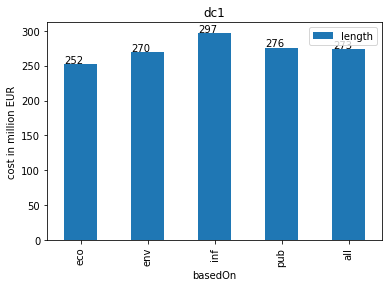

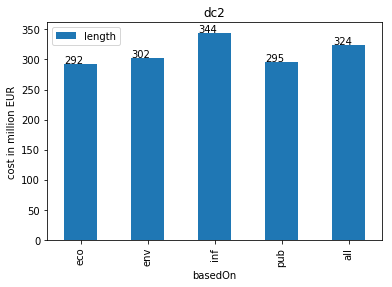

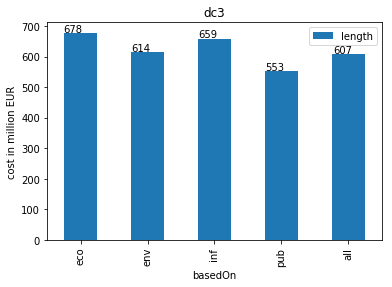

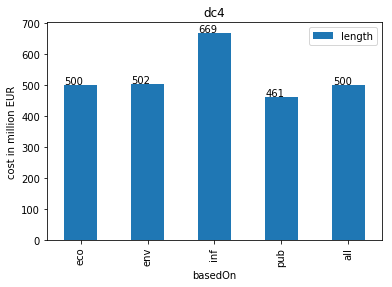

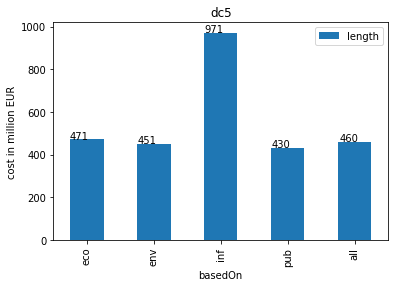

In [62]:
for line in lines:
    dcLine = lengths[['dc','path_based_on','length']].loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylabel('cost in million EUR')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'length_'+line)))
    plt.show()

## Length through Protected zone

In [37]:
protZone = raster2array(os.path.abspath('01_Data500/protected.tif'))

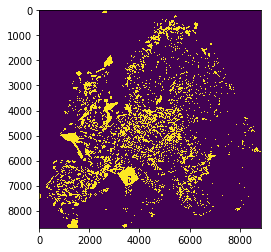

In [38]:
plt.imshow(protZone)

In [58]:
proCostAll = []
for line in lines:
    for factor in factors:
        linePath = line_path(path_based_on=factor, 
                             dc = line)
        proCost  = np.multiply(protZone, linePath)/10
        proLenthPass = lineLength(proCost)
        proCostAll.append([factor,line,proLenthPass])

In [59]:
proCostAllDC = pd.DataFrame(proCostAll,
                           columns=['path_based_on',
                                   'dc','protZoneLength'])

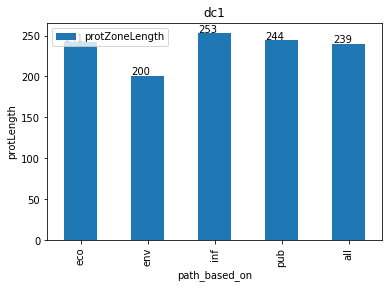

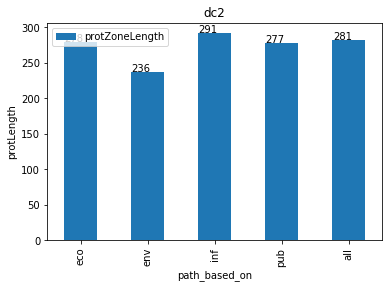

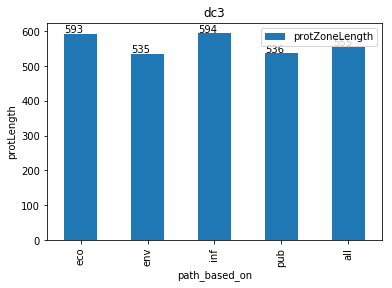

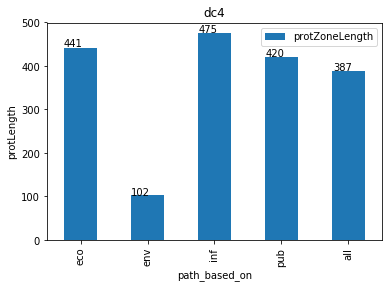

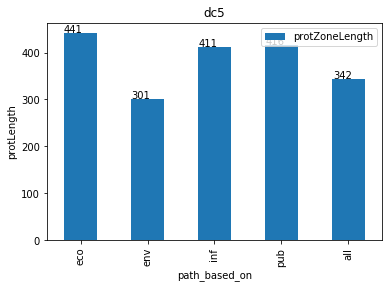

In [61]:
for line in lines:
    dcLine = proCostAllDC[['dc','path_based_on','protZoneLength']].loc[lengths['dc']==line]
    ax = dcLine.set_index('path_based_on').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylabel('protLength')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'protLength_'+line)))
    plt.show()

length
dc  path_based_on            
dc1 eco            252.610173
    env            270.109785
    inf            297.256781
    pub            276.012002
    all            273.611994
dc2 eco            292.436075
    env            302.482653
    inf            344.182531
    pub            295.152351
    all            324.295536
dc3 eco            678.122278
    env            614.228192
    inf            659.397243
    pub            553.388348
    all            607.855930
dc4 eco            500.966785
    env            502.183860
    inf            669.084930
    pub            461.988853
    all            500.840714
dc5 eco            471.676490
    env            451.692958
    inf            971.422566
    pub            430.903066
    all            460.939309

In [76]:
dc_lengthPro = lengths.set_index(['dc','path_based_on']).join(proCostAllDC.set_index(['dc','path_based_on']))

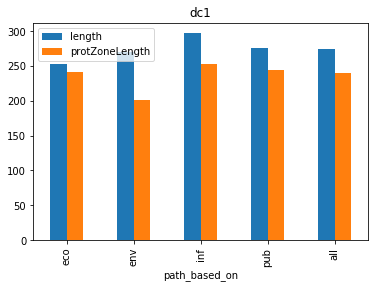

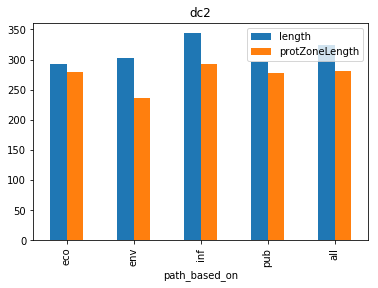

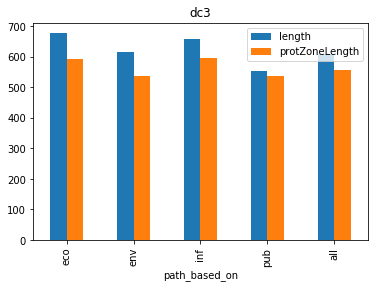

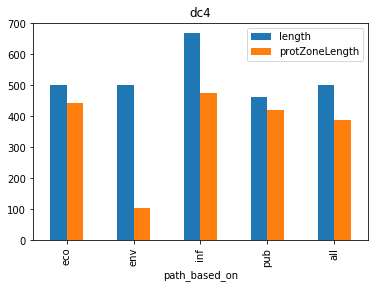

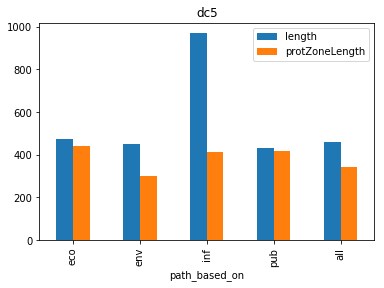

In [79]:
for line in lines:
    lineLenghts = dc_lengthPro.xs(line).plot(kind='bar')
    lineLenghts.plot(kind='bar')
    plt.title(line)
    plt.savefig(os.path.abspath(
        str('02_DC_Projects_DE/01_graphs/lengthProt_'+line)))

# Population Affected

In [27]:
popu = raster2array(os.path.abspath('01_Data500/population.tif'))

In [28]:
def peopleAffected(line, basedOn):
    path = line_path(path_based_on=basedOn, dc = line)
    return np.multiply(popu,path).sum()

In [29]:
peopleAffectedAll = []
for line in lines:
    for factor in factors:
        print(line, factor)
        peopleAff = peopleAffected(line, factor)
        peopleAffectedAll.append([line,factor, peopleAff])

peopleAff = pd.DataFrame(peopleAffectedAll)
peopleAff.columns=['dc','basedOn','peopleAffected']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


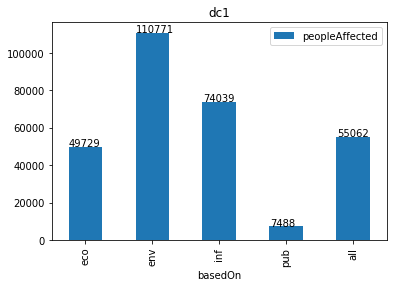

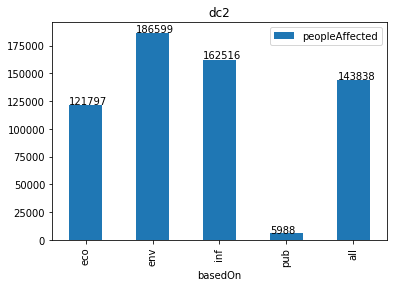

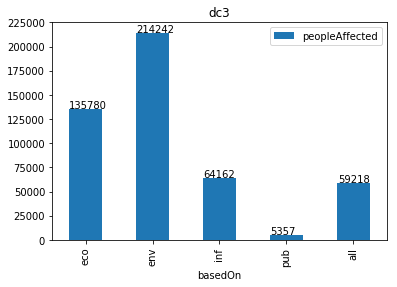

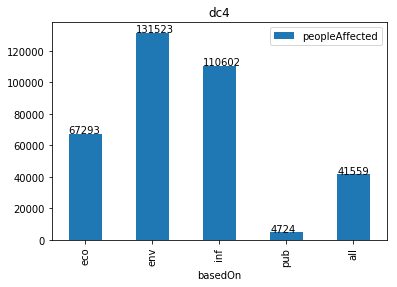

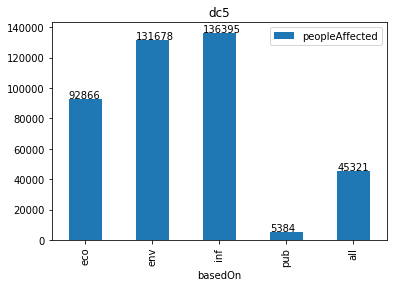

In [30]:
for line in lines:
    dcLine = peopleAff.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'peopleAff_'+line)))
    plt.show()

# Costs Based on renders 

In [80]:
def getCosts(path_based_on, dc):
    linePath = line_path(path_based_on=path_based_on, dc = dc)
    ecoCostLine = np.multiply(ecoCost, linePath).sum()
    envCostLine = np.multiply(envCost, linePath).sum()
    infCostLine = np.multiply(infCost, linePath).sum()
    pubCostLine = np.multiply(pubCost, linePath).sum()
    allCostLine = np.multiply(allCost, linePath).sum()
    return [ecoCostLine, envCostLine, infCostLine, pubCostLine, allCostLine]

In [32]:
def allCosts(line):
    cost = []
    for factor in factors:
        print(factor)
        facCost = getCosts(path_based_on=factor, dc=line)
        cost.append(facCost)
    allCost = pd.DataFrame(cost)
    allCost.columns=['eco','env','inf','pub','all']
    allCost['path_on'] = ['p_eco','p_env','p_inf','p_pub','p_all']
    return allCost.set_index('path_on')

In [84]:
def costGraph(data, title):
    data.plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.png')))
    plt.show()
    
    

def costDiffGraph(data, title):
    data.sub(data.xs('p_all'),axis=1).plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.png')))
    plt.show()
    

    
def costDiffNormGraph(data, title):
    data.sub(data.xs('p_all'), axis=1).div(data.xs('p_all'),axis=1).plot(kind='bar', cmap=cmap)
    plt.title(title)
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.png')))
    plt.show()
    

eco
env
inf
pub
all


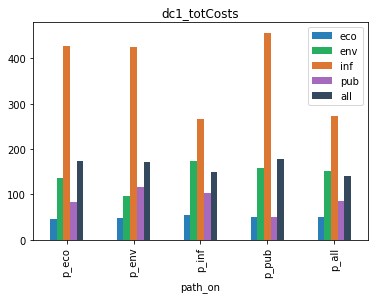

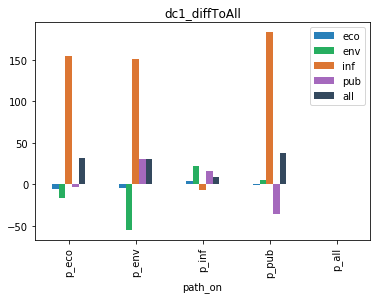

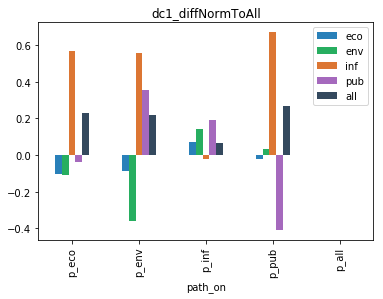

eco
env
inf
pub
all


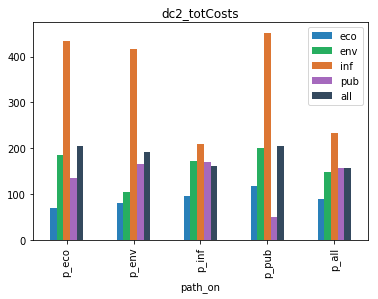

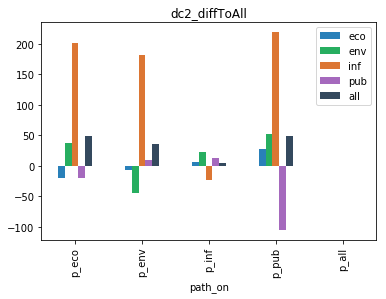

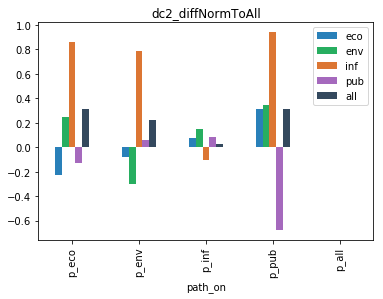

eco
env
inf
pub
all


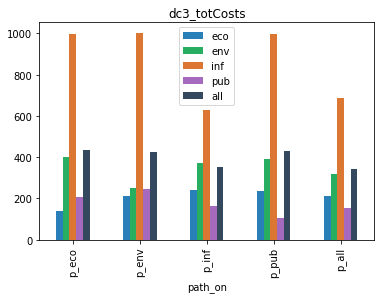

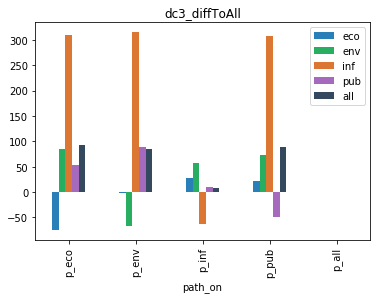

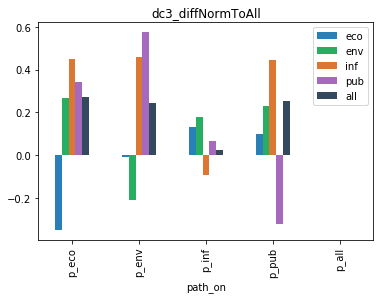

eco
env
inf
pub
all


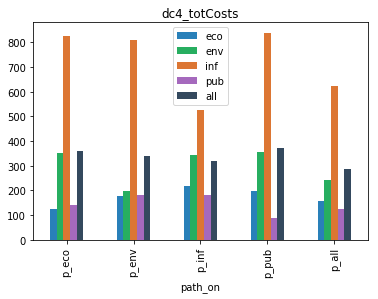

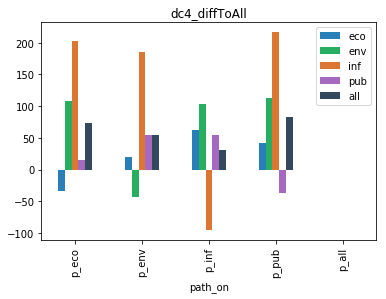

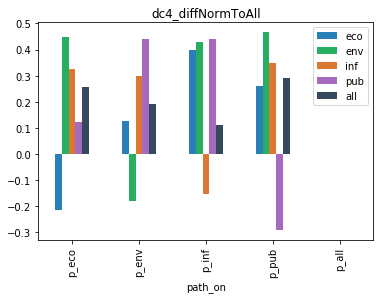

eco
env
inf
pub
all


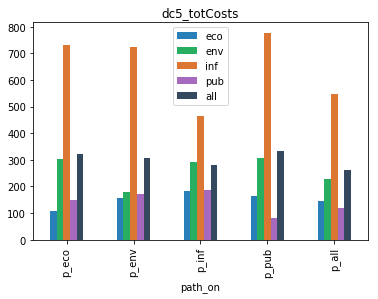

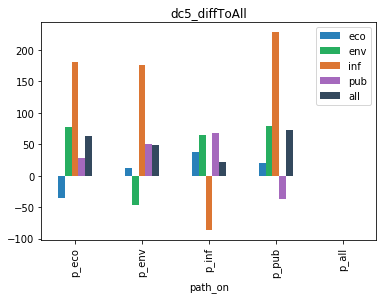

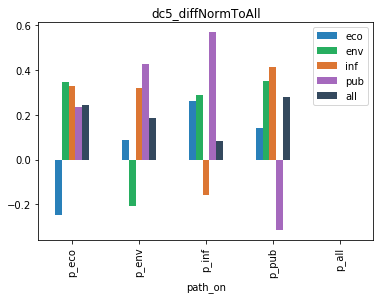

In [85]:
for line in lines:
    lineCosts = allCosts(line)
    costGraph(lineCosts, str(line+'_totCosts'))
    costDiffGraph(lineCosts, str(line+'_diffToAll'))
    costDiffNormGraph(lineCosts, str(line+'_diffNormToAll'))

241.79973861444495